In [250]:
#reference
#https://www.kaggle.com/kernels/scriptcontent/27391487/download
#https://www.kaggle.com/noeasywayout/eda-fe-lgbm-model

# 1C Sales prediction

In [251]:
#!pip3 install lofo-importance

In [252]:
#!pip3 install pandarallel

In [1]:
import numpy as np
import pandas as pd
import dateutil
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from pandarallel import pandarallel

import seaborn as sns
import re
import gc
from tqdm import tqdm
import pickle
import statsmodels.api as sm
from pylab import rcParams
from itertools import permutations, product
import lightgbm as lgb
from lightgbm import LGBMRegressor
#from lofo import LOFOImportance, FLOFOImportance, Dataset, plot_importance
from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold
import warnings
print(1)

1


Reduce RAM usage. From https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction:

In [2]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Import and prepare data

In [6]:
train_df = pd.read_csv('../input/sales_train.csv')
test_df = pd.read_csv('../input/test.csv')
item_df = pd.read_csv('../input/items.csv')
item_cat_df = pd.read_csv('../input/item_categories.csv')
shop_df = pd.read_csv('../input/shops.csv')

USD/RUB exchange rate taken from https://www.finam.ru/profile/forex/usd-rub/export/ :

In [7]:
exch_rate = pd.read_csv('../input/USDRUB_130101_160701.csv',
                        sep=',', parse_dates=['<DATE>'])
exch_rate = exch_rate.drop(['<TICKER>', '<PER>', '<TIME>',
                           '<OPEN>', '<HIGH>', '<LOW>', '<VOL>'], axis=1)
exch_rate = exch_rate.rename(columns={'<DATE>':'date', '<CLOSE>':'rate'})

In [8]:
exch_rate.head(3)

,date,rate
0,2013-01-01,30.57
1,2013-01-02,30.18
2,2013-01-03,30.25


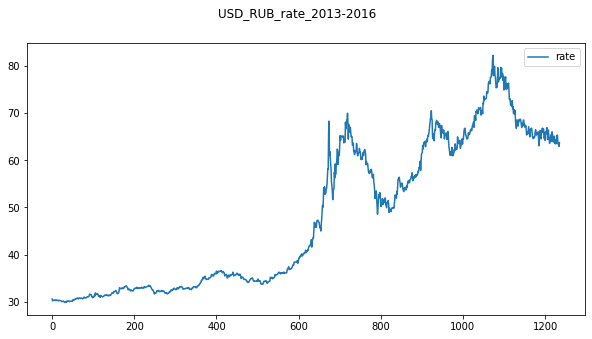

In [9]:
fig = plt.figure(figsize=(10, 5))
fig.suptitle('USD_RUB_rate_2013-2016')
exch_rate.rate.plot()
plt.legend()

Parsing dates (pandarallel function parallel_apply):

In [10]:
train_df.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


In [11]:
import time

In [12]:
start = time.time()
train_df['date_test'] = pd.to_datetime(train_df.date, format='%d.%m.%Y')
print(time.time() - start)

0.17281007766723633


In [13]:
start = time.time()
train_df['date'] = train_df['date']\
                   .apply(dateutil.parser.parse, dayfirst=True)
print(time.time() - start)

95.49717092514038


In [14]:
train_df.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_test
0,2013-01-02,0,59,22154,999.0,1.0,2013-01-02
1,2013-01-03,0,25,2552,899.0,1.0,2013-01-03
2,2013-01-05,0,25,2552,899.0,-1.0,2013-01-05


### Items data

    Borrowed from https://www.kaggle.com/kyakovlev/1st-place-solution-part-1-hands-on-data :

In [15]:
def name_correction(x):
    x = x.lower()
    x = x.partition('[')[0]
    x = x.partition('(')[0]
    x = re.sub('[^A-Za-z0-9А-Яа-я]+', ' ', x)
    x = x.replace('  ', ' ')
    x = x.strip()
    return x

In [16]:
item_df.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [17]:
item_df.item_name.unique().shape

(22170,)

In [18]:
item_df['item_name'] = item_df['item_name'].apply(name_correction)

In [19]:
item_df.head(5)

,item_name,item_id,item_category_id
0,во власти наваждения,0,40
1,abbyy finereader 12 professional edition full,1,76
2,в лучах славы,2,40
3,голубая волна,3,40
4,коробка,4,40


In [20]:
item_df.item_name.unique().shape

(18121,)

There are some repeating items in the dataset

### Item categories data

In [21]:
item_cat_df['new_cats'] = (item_cat_df['item_category_name']
                           .str.split(' - ').apply(lambda x: x[0]))

In [22]:
item_cat_df['new_cats'].unique()

array(['PC', 'Аксессуары', 'Билеты (Цифра)', 'Доставка товара',
       'Игровые консоли', 'Игры', 'Игры Android', 'Игры MAC', 'Игры PC',
       'Карты оплаты (Кино, Музыка, Игры)', 'Карты оплаты', 'Кино',
       'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители (шпиль)', 'Чистые носители (штучные)',
       'Элементы питания'], dtype=object)

In [23]:
item_cat_df['new_subcats'] = (item_cat_df['item_category_name']
                           .str.split(' - ').apply(lambda x: x[-1]))

In [24]:
item_cat_df['new_subcats'].unique()

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты (Цифра)', 'Доставка товара',
       'Прочие', 'Аксессуары для игр', 'Цифра', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания',
       'Карты оплаты (Кино, Музыка, Игры)', 'Live!', 'Live! (Цифра)',
       'PSN', 'Windows (Цифра)', 'Blu-Ray', 'Blu-Ray 3D', 'Blu-Ray 4K',
       'DVD', 'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Аудиокниги (Цифра)', 'Аудиокниги 1С', 'Бизнес литература',
       'Комиксы, манга', 'Компьютерная литература',
       'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры',
       'Настольные игры (компактные)', 'Открытки, на

### Shops data

Retrieving cities from the shop names:

In [25]:
shop_df.head(10)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [26]:
shop_df['city'] = (shop_df['shop_name'].apply(name_correction)
                   .str.split(' ').apply(lambda x: x[0]))

In [27]:
shop_df['city'].value_counts()

москва          13
якутск           4
тюмень           3
воронеж          3
ростовнадону     3
новосибирск      2
спб              2
казань           2
жуковский        2
н                2
самара           2
красноярск       2
уфа              2
волжский         1
вологда          1
омск             1
калуга           1
чехов            1
цифровой         1
сергиев          1
томск            1
химки            1
мытищи           1
выездная         1
адыгея           1
балашиха         1
коломна          1
сургут           1
ярославль        1
курск            1
интернет         1
Name: city, dtype: int64

In [28]:
shop_df.loc[shop_df['city']=='н', 'city']

34    н
35    н
Name: city, dtype: object

In [29]:
shop_df.loc[shop_df['city']=='н', 'city'] = 'нижний_новгород'

Retrieving shop types:

In [30]:
shop_df['shop_type'] = (shop_df['shop_name'].apply(name_correction)
                       .str.split(' ')\
                       .apply(lambda x: x[1] if (len(x)>1) else 'other'))

In [31]:
shop_df['shop_type'].value_counts()

тц              27
трц              9
трк              5
тк               5
ул               2
новгород         2
магазин          2
орджоникидзе     2
распродажа       1
мтрц             1
склад            1
other            1
посад            1
торговля         1
Name: shop_type, dtype: int64

Renaming and merging some of the types:

In [32]:
shop_type_other = ((shop_df['shop_type']=='орджоникидзе')|
                  (shop_df['shop_type']=='ул')|
                  (shop_df['shop_type']=='распродажа')|
                  (shop_df['shop_type']=='торговля')|
                  (shop_df['shop_type']=='магазин'))
shop_df.loc[shop_type_other]

,shop_name,shop_id,city,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,якутск,орджоникидзе
9,Выездная Торговля,9,выездная,торговля
10,Жуковский ул. Чкалова 39м?,10,жуковский,ул
11,Жуковский ул. Чкалова 39м²,11,жуковский,ул
12,Интернет-магазин ЧС,12,интернет,магазин
20,"Москва ""Распродажа""",20,москва,распродажа
22,Москва Магазин С21,22,москва,магазин
57,"Якутск Орджоникидзе, 56",57,якутск,орджоникидзе


In [33]:
shop_df.loc[shop_type_other, 'shop_type'] = 'other'

In [34]:
shop_df.loc[(shop_df['shop_type']=='трц'),:]

,shop_name,shop_id,city,shop_type
5,"Вологда ТРЦ ""Мармелад""",5,вологда,трц
7,"Воронеж ТРЦ ""Максимир""",7,воронеж,трц
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,воронеж,трц
15,"Калуга ТРЦ ""XXI век""",15,калуга,трц
36,"Новосибирск ТРЦ ""Галерея Новосибирск""",36,новосибирск,трц
47,"Сургут ТРЦ ""Сити Молл""",47,сургут,трц
48,"Томск ТРЦ ""Изумрудный Город""",48,томск,трц
49,"Тюмень ТРЦ ""Кристалл""",49,тюмень,трц
56,"Чехов ТРЦ ""Карнавал""",56,чехов,трц


In [35]:
shop_df.loc[(shop_df['shop_type']=='новгород')|
           (shop_df['shop_type']=='мтрц'),:]

,shop_name,shop_id,city,shop_type
21,"Москва МТРЦ ""Афи Молл""",21,москва,мтрц
34,"Н.Новгород ТРЦ ""РИО""",34,нижний_новгород,новгород
35,"Н.Новгород ТРЦ ""Фантастика""",35,нижний_новгород,новгород


In [36]:
shop_df.loc[(shop_df['shop_type']=='новгород')|
           (shop_df['shop_type']=='мтрц'), 'shop_type'] = 'трц'

In [37]:
shop_df.loc[(shop_df['shop_type']=='посад'), :]

,shop_name,shop_id,city,shop_type
46,"Сергиев Посад ТЦ ""7Я""",46,сергиев,посад


In [38]:
shop_df.loc[(shop_df['shop_type']=='тц'), :].head(5)

,shop_name,shop_id,city,shop_type
1,"!Якутск ТЦ ""Центральный"" фран",1,якутск,тц
2,"Адыгея ТЦ ""Мега""",2,адыгея,тц
4,"Волжский ТЦ ""Волга Молл""",4,волжский,тц
13,"Казань ТЦ ""Бехетле""",13,казань,тц
14,"Казань ТЦ ""ПаркХаус"" II",14,казань,тц


In [39]:
shop_df.loc[(shop_df['shop_type']=='посад'),
            'shop_type'] = 'тц'

In [40]:
shop_df['shop_type'].value_counts()

тц       28
трц      12
other     9
тк        5
трк       5
склад     1
Name: shop_type, dtype: int64

### Merging everything together

In [41]:
item_df = pd.merge(item_df, item_cat_df[['item_category_id', 'new_cats', 'new_subcats']])

In [42]:
item_df = item_df.rename(columns={'new_cats': 'item_category',
                                  'new_subcats': 'item_subcategory'})

In [43]:
train_df = pd.merge(train_df, item_df[['item_name', 'item_id',
                                      'item_category', 'item_subcategory']])

In [44]:
train_df = pd.merge(train_df, shop_df[['city', 'shop_type', 'shop_id']])

In [45]:
train_df = pd.merge(train_df, exch_rate)

In [46]:
train_df['price_usd'] = train_df['item_price'] / train_df['rate']
train_df['revenue'] = train_df['item_price'] * train_df['item_cnt_day']
train_df['revenue_usd'] = train_df['price_usd']*train_df['item_cnt_day']

In [47]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_test,item_name,item_category,item_subcategory,city,shop_type,rate,price_usd,revenue,revenue_usd
0,2013-01-02,0,59,22154,999.0,1.0,2013-01-02,явление 2012,Кино,Blu-Ray,ярославль,тц,30.18,33.101392,999.0,33.101392
1,2013-01-02,0,59,2746,299.0,2.0,2013-01-02,dead space 2,Игры PC,Стандартные издания,ярославль,тц,30.18,9.907223,598.0,19.814447
2,2013-01-02,0,59,2847,1699.0,1.0,2013-01-02,disney история игрушек парк развлечений,Игры,XBOX 360,ярославль,тц,30.18,56.295560,1699.0,56.295560
3,2013-01-02,0,59,2848,99.0,1.0,2013-01-02,disney мир героев,Игры PC,Стандартные издания,ярославль,тц,30.18,3.280318,99.0,3.280318
4,2013-01-02,0,59,2854,449.0,1.0,2013-01-02,disney храбрая сердцем,Игры PC,Стандартные издания,ярославль,тц,30.18,14.877402,449.0,14.877402


## EDA:

### __Price distribution:__

Text(0.5, 1.0, 'item_price distplot')

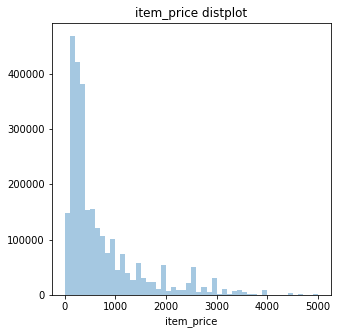

In [48]:
plt.figure(figsize=(5, 5))
sns.distplot(train_df.loc[train_df['item_price']<5000, 'item_price'], 
             kde=False)
plt.title('item_price distplot')

There is an entry with negative price:

In [49]:
train_df.loc[train_df['item_price']<0, :]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,date_test,item_name,item_category,item_subcategory,city,shop_type,rate,price_usd,revenue,revenue_usd
1267109,2013-05-15,4,32,2973,-1.0,1.0,2013-05-15,dmc devil may cry,Игры,PS3,москва,тц,31.45,-0.031797,-1.0,-0.031797


Filling it with the mean price of this particular item:

In [50]:
train_df.loc[train_df['item_price']<0, 'item_price'] = \
train_df.loc[train_df['item_id']\
             ==train_df.loc[train_df['item_price']<0,'item_id']\
                            .values[0],
                            'item_price'].mean()

Replotting in log10 scale:

Text(0.5, 1.0, 'log10(item_price) distplot')

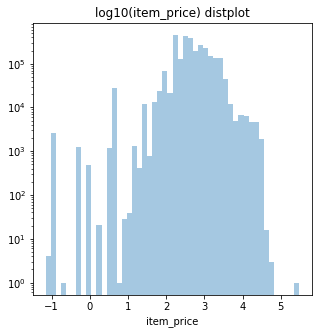

In [51]:
plt.figure(figsize=(5, 5))
sns.distplot(np.log10(train_df['item_price']), kde=False)
plt.yscale('log')
plt.title('log10(item_price) distplot')

In [52]:

train_df = train_df.loc[(train_df['item_price']<10**5), :]

### __Item count per day__ distribution:

Text(0.5, 1.0, 'item_cnt_day distplot')

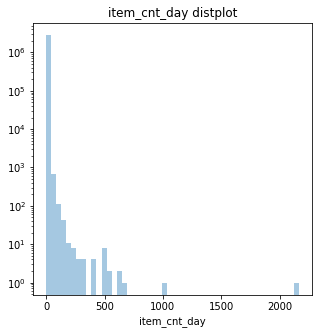

In [53]:
plt.figure(figsize=(5, 5))
sns.distplot(train_df.loc[(train_df['item_cnt_day']<10000)&(train_df['item_cnt_day']>-5),
                          'item_cnt_day'], kde=False)

plt.yscale('log')
plt.title('item_cnt_day distplot')

In [54]:
train_df.shape

(2770693, 16)

In [55]:
train_df = train_df.loc[(train_df['item_cnt_day']<750), :]

In [56]:
train_df.shape

(2770691, 16)

### __Item counts versus item prices__

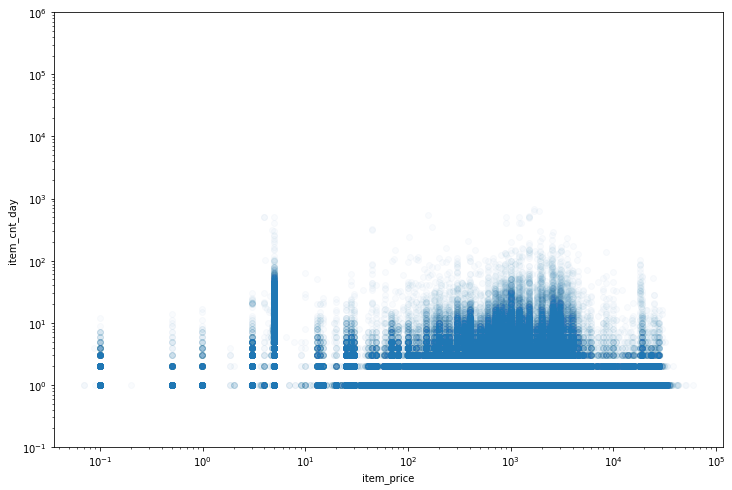

In [57]:
plt.figure(figsize=(12, 8))
plt.scatter(train_df['item_price'], train_df['item_cnt_day'], alpha=0.025)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('item_price')
plt.ylabel('item_cnt_day')
plt.ylim((1e-1, 1e6))
plt.show()

Around 90% of all daily sales include only one item:

In [58]:
train_df.loc[train_df['item_cnt_day']==1, :].shape[0] / train_df.shape[0]

0.8962063976098381

In [59]:
t_df = train_df.groupby(['date_block_num', 'item_id', 'shop_id'])[['item_cnt_day']].sum()
t_df = t_df.reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})

In case of monthly sales, this value is of around 70%:

In [60]:
t_df.loc[t_df['item_cnt_month']==1, :].shape[0] / t_df.shape[0]

0.6644081798614315

However, in 95% of all cases, the monthly sales volume is not greater than 5:

In [61]:
t_df.loc[t_df['item_cnt_month']<=5, :].shape[0] / t_df.shape[0]

0.9448611250052439

In [62]:
del t_df
gc.collect()

17777

### __Total sales behaviour depending on month/year__

In [63]:
t_df = train_df[['item_cnt_day', 'date']].copy()

In [64]:
t_df['month'] = t_df['date'].dt.month
t_df['year'] = t_df['date'].dt.year

In [65]:
t_df.groupby(
    ['year','month']).agg({'item_cnt_day': np.sum}).reset_index().head(5)

,year,month,item_cnt_day
0,2013,1,131479.0
1,2013,2,128090.0
2,2013,3,141773.0
3,2013,4,107190.0
4,2013,5,95315.0


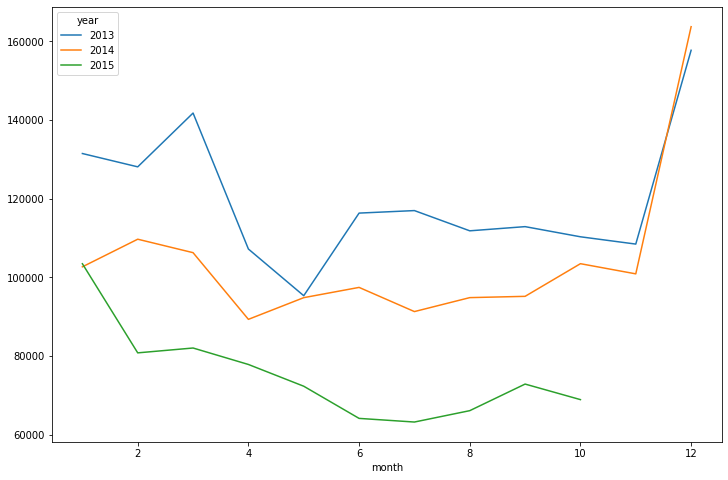

In [66]:
data = t_df.groupby(
    ['year','month']).agg({'item_cnt_day': np.sum}).reset_index()\
    .pivot(index='month', columns='year', values='item_cnt_day')
data.plot(figsize=(12, 8))

In [67]:
del t_df, data
gc.collect()

32

### __Seasonal decomposition:__

In [68]:
temp_sum = train_df.groupby(['date_block_num'])[['item_cnt_day', 'revenue', 'revenue_usd']].sum()
temp_sum = temp_sum.reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})

Cumulative __sales volume__:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


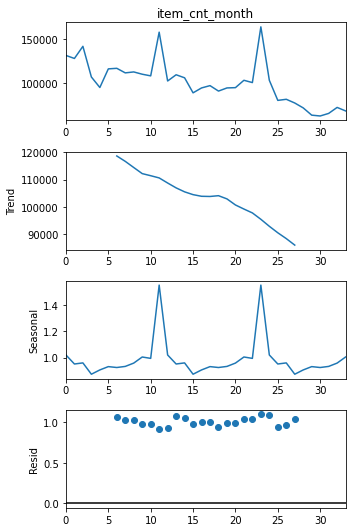

In [69]:
rcParams['figure.figsize'] = 5, 7.5
decomposition = sm.tsa.seasonal_decompose(temp_sum['item_cnt_month'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

Cumulative __revenue__:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


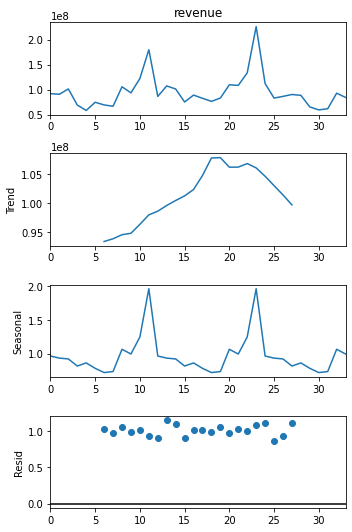

In [70]:
decomposition = sm.tsa.seasonal_decompose(temp_sum['revenue'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

In [71]:
temp_mean = train_df.groupby(['date_block_num'])[['item_cnt_day', 'revenue', 'revenue_usd']].mean()
temp_mean = temp_mean.reset_index().rename(columns={'item_cnt_day': 'item_cnt_mean',
                                                    'revenue': 'av_revenue'})

Average __sales volume__:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


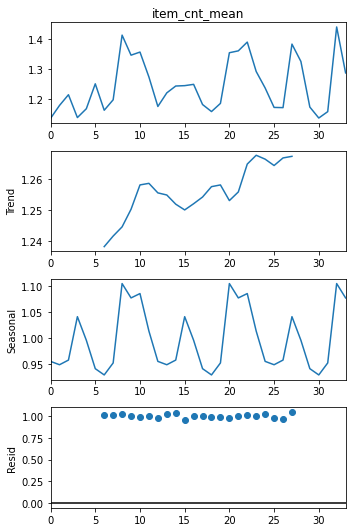

In [72]:
decomposition = sm.tsa.seasonal_decompose(temp_mean['item_cnt_mean'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

Average __revenue__:

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


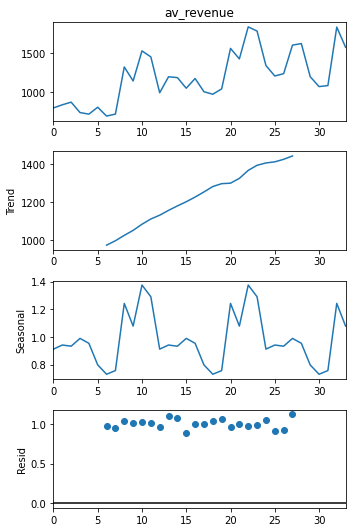

In [73]:
decomposition = sm.tsa.seasonal_decompose(temp_mean['av_revenue'], freq=12, model='multiplicative')
fig = decomposition.plot()
plt.show()

There is a __clear seasonality__ in both overall amount of sales and average sales per day. Moreover, there seems to be a __negative trend__ for the former and a __positive one__ for the latter.  
If one looks at the __revenues__, it can be seen that even though the __seasonality__ persists here, there is __no clear trend__ in case of cumulative value. The __average revenues__ follow the behaviour of the average number of sales.

In [74]:
del temp_mean, temp_sum
gc.collect()

25543

### Sales distributions by __shop_id__:

In [75]:
shop_sum = train_df.groupby(['shop_id'], as_index=False)[['item_cnt_day', 'revenue']].sum()
shop_mean = train_df.groupby(['shop_id'], as_index=False)[['item_cnt_day', 'revenue']].mean()

In [76]:
shop_sum = shop_sum.rename(columns={'item_cnt_day': 'item_cnt_sum'}).sort_values(by='item_cnt_sum')
shop_mean = shop_mean.rename(columns={'item_cnt_day': 'item_cnt_mean'})

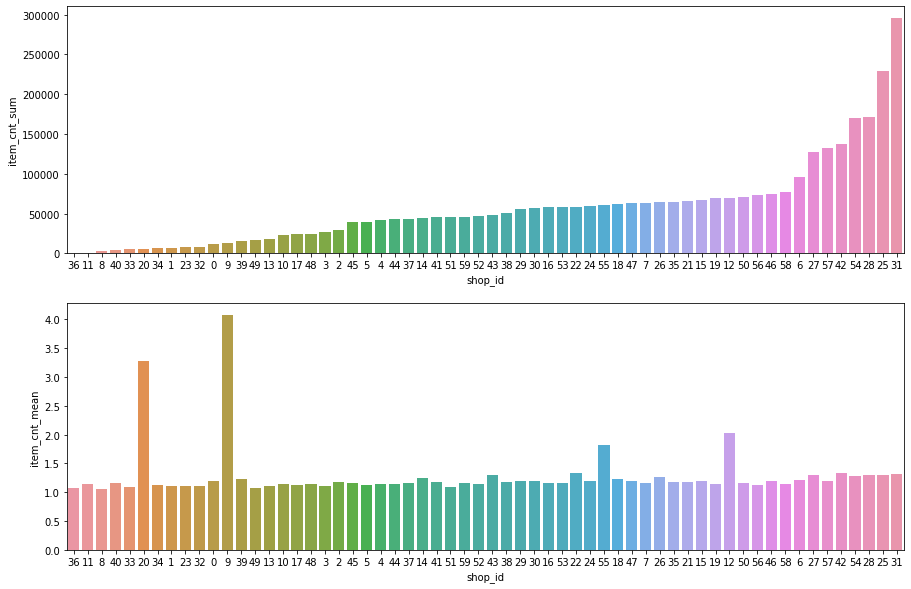

In [77]:
f, axes = plt.subplots(2, 1, figsize=(15, 10))
sns.barplot(x=shop_sum['shop_id'], y=shop_sum['item_cnt_sum'], ax=axes[0], order=shop_sum['shop_id'])
sns.barplot(x=shop_mean['shop_id'], y=shop_mean['item_cnt_mean'], ax=axes[1], order=shop_sum['shop_id'])
plt.show()

Whereas the average number daily sales is around 1 for all the shops, there are several shops having larger cumulative amount of sales.

As one can see, these are mostly located in Moscow and its outskirts:

In [78]:
pd.merge(shop_sum, shop_df).tail()

,shop_id,item_cnt_sum,revenue,shop_name,city,shop_type
55,42,137989.0,1.454613e+08,"СПб ТК ""Невский Центр""",спб,тк
56,54,170551.0,1.315888e+08,"Химки ТЦ ""Мега""",химки,тц
57,28,170961.0,1.491373e+08,"Москва ТЦ ""МЕГА Теплый Стан"" II",москва,тц
58,25,229700.0,2.076013e+08,"Москва ТРК ""Атриум""",москва,трк
59,31,295745.0,2.254598e+08,"Москва ТЦ ""Семеновский""",москва,тц


In [79]:
del shop_sum, shop_mean
gc.collect()

55

### Sales distribution by __item_category__:

In [80]:
item_sum = train_df.groupby(['item_category'], as_index=False)[['item_cnt_day', 'revenue']].sum()
item_mean = train_df.groupby(['item_category'], as_index=False)[['item_cnt_day', 'revenue']].mean()

In [81]:
item_sum = item_sum.rename(columns={'item_cnt_day': 'item_cnt_sum',
                                   'revenue': 'revenue_sum'}).sort_values(by='item_cnt_sum')
item_mean = item_mean.rename(columns={'item_cnt_day': 'item_cnt_mean',
                                     'revenue': 'av_revenue'})

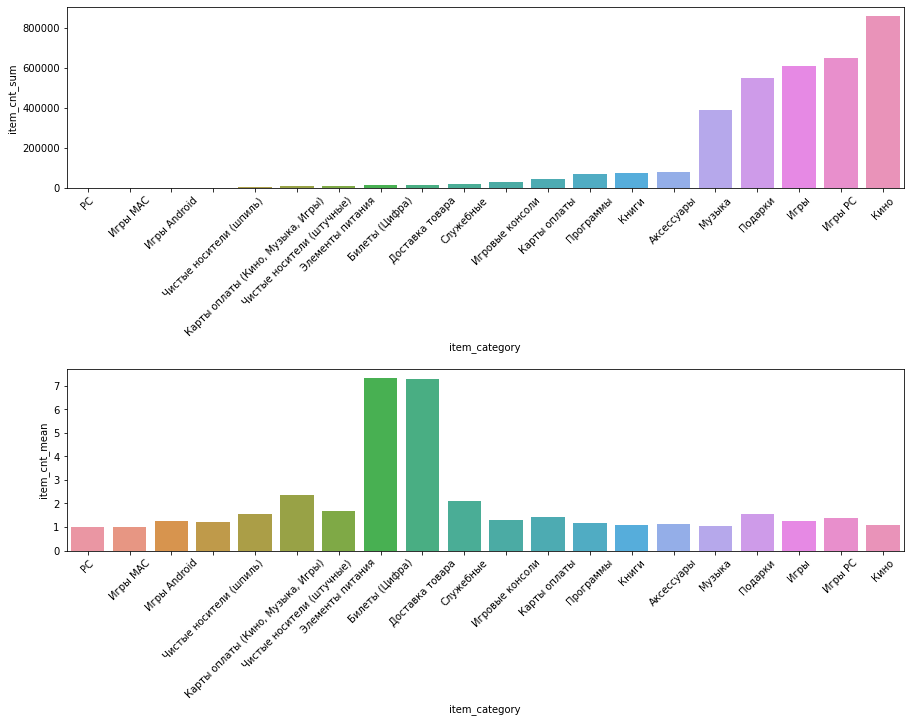

In [82]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(x=item_sum['item_category'], y=item_sum['item_cnt_sum'], ax=axes[0],
            order=item_sum['item_category'])
sns.barplot(x=item_mean['item_category'], y=item_mean['item_cnt_mean'], ax=axes[1],
            order=item_sum['item_category'])
plt.subplots_adjust(hspace=1)
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.show()

There are top 5 product categories dominating the overall sales volume.

Taking a look at what's happening inside the top category (__'Movies'__):

In [83]:
movies_df = train_df.loc[train_df['item_category']=='Кино',
             :].groupby('item_id', as_index=False).sum()[['item_id', 'item_cnt_day']]

In [84]:
top20_movies = pd.merge(movies_df, item_df).sort_values(by='item_cnt_day', ascending=False).head(20)

In [85]:
top20_movies = top20_movies.rename(columns={'item_cnt_day': 'item_cnt_sum'})

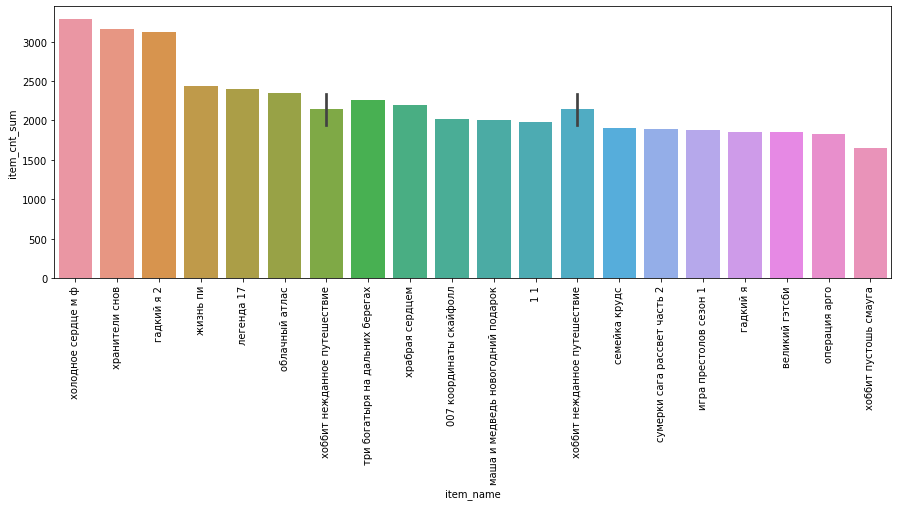

In [86]:
plt.figure(figsize=(15, 5))
sns.barplot(x=top20_movies['item_name'], y=top20_movies['item_cnt_sum'],
            order=top20_movies['item_name'])
plt.xticks(rotation=90)
plt.show()

The distribution of the sales in the top category ('Movies') is monotonous, no peculiarities are observed

In [87]:
del top20_movies
gc.collect()

33558

### __Revenues__ distribution by category:

In [88]:
item_sum = item_sum.sort_values(by='revenue_sum')

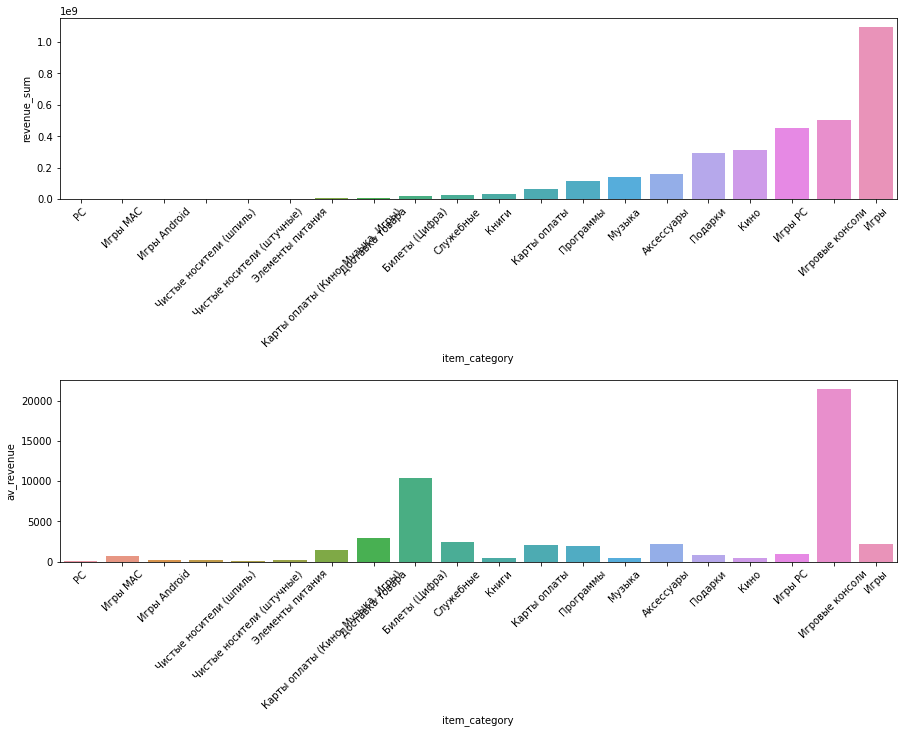

In [89]:
f, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=False)
sns.barplot(x=item_sum['item_category'], y=item_sum['revenue_sum'], ax=axes[0],
            order=item_sum['item_category'])
sns.barplot(x=item_mean['item_category'], y=item_mean['av_revenue'], ax=axes[1],
            order=item_sum['item_category'])
plt.subplots_adjust(hspace=1)
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
plt.show()

Even though the volume is mostly determined by one set of categories, the situation in case of revenue is slightly different. One can see, for instance that __'Games'__ becomes the top category instead of __'Movies'__. The __'Game consoles'__, despite having relatively low volume, gets the second place due to its high price.

In [90]:
del item_sum, item_mean
gc.collect()

11515

Taking a look at what's happening __inside the top categories__:

In [91]:
games_df = train_df.loc[train_df['item_category']=='Игры',
             :].groupby('item_id', as_index=False).sum()[['item_id', 'revenue', 'item_cnt_day']]

In [92]:
top20_games = pd.merge(games_df, item_df).sort_values(by='revenue', ascending=False).head(20)

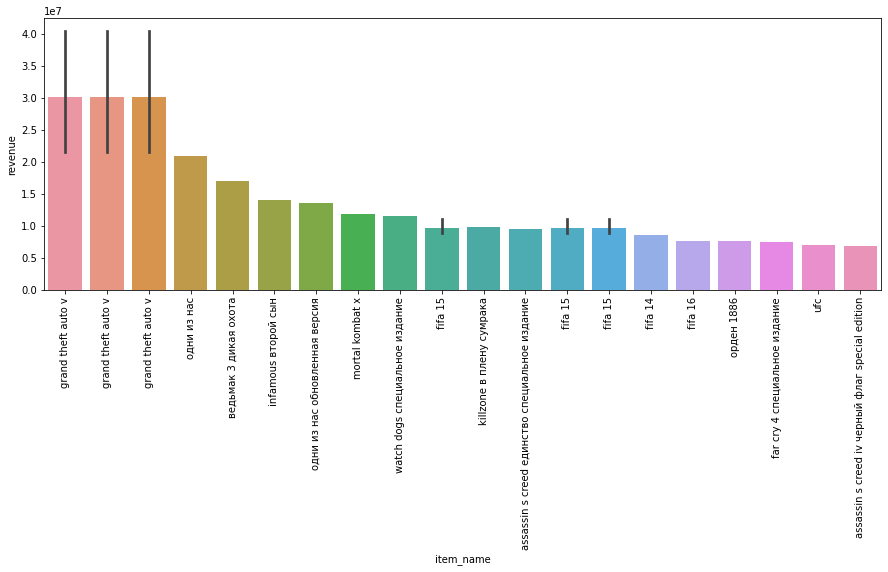

In [93]:
plt.figure(figsize=(15, 5))
sns.barplot(x=top20_games['item_name'], y=top20_games['revenue'],
            order=top20_games['item_name'])
plt.xticks(rotation=90)
plt.show()

In [94]:
consoles_df = train_df.loc[train_df['item_category']=='Игровые консоли',
             :].groupby('item_id', as_index=False).sum()[['item_id', 'revenue', 'item_cnt_day']]

In [95]:
top20_consoles = pd.merge(consoles_df, item_df).sort_values(by='revenue', ascending=False).head(20)

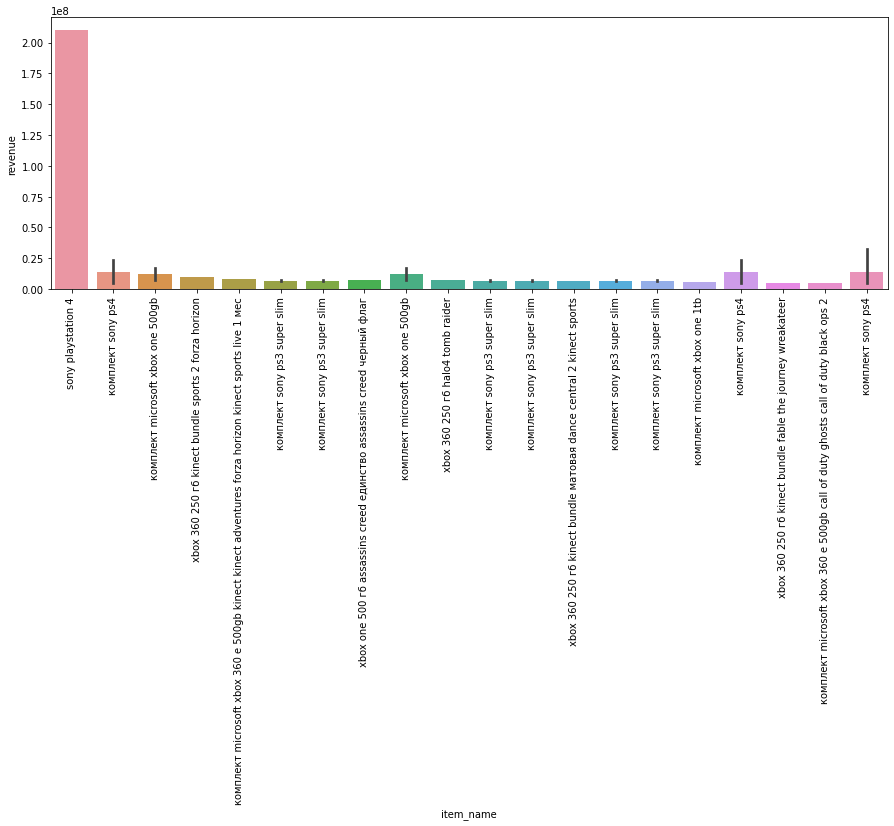

In [96]:
plt.figure(figsize=(15, 5))
sns.barplot(x=top20_consoles['item_name'], y=top20_consoles['revenue'],
            order=top20_consoles['item_name'])
plt.xticks(rotation=90)
plt.show()

## Preparing target variable:

Looking at the test set:

In [97]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [98]:
test_df.shape

(214200, 3)

In [99]:
pd.DataFrame(product(*[test_df['shop_id'].unique(),
                       test_df['item_id'].unique()])).shape

(214200, 2)

Strangely enough, the test set contains a product (i.e. all possible combinations) of all the unique shops and items in it. Seems logical to do something similar with the train set...

### Including all possible combinations of unique shops/items for each month in the train set:

In [100]:
gr_date = train_df.groupby('date_block_num')

In [101]:
t_d = gr_date.apply(lambda x: product(*[[x.name],
                                        x['shop_id'].unique(),
                                        x['item_id'].unique()]))

In [102]:
all_vals = pd.DataFrame()
for t in tqdm(t_d.values):
    all_vals = pd.concat([all_vals, pd.DataFrame(t)], axis=0)

100%|██████████| 34/34 [00:06<00:00,  5.22it/s]


In [103]:
all_vals.columns = ['date_block_num', 'shop_id', 'item_id']
all_vals.head()

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2746
2,0,59,2847
3,0,59,2848
4,0,59,2854


Adding test shops/items @ last month:

In [104]:
test_vals = pd.DataFrame()
test_vals['shop_id'] = test_df['shop_id'].copy()
test_vals['item_id'] = test_df['item_id'].copy()
test_vals['date_block_num'] = 34

In [105]:
all_vals = pd.concat([all_vals, test_vals], axis=0)

In [106]:
all_vals.head(3)

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,2746
2,0,59,2847


### Target variable:

In [107]:
month_sum = train_df.groupby(['shop_id',
                             'item_id',
                             'date_block_num']).sum()

In [108]:
month_sum.shape

(1549415, 6)

In [109]:
month_sum = month_sum.rename(columns={'item_cnt_day':'item_cnt_month'})

In [110]:
month_sum.head()

item_price  item_cnt_month    rate  \
shop_id item_id date_block_num                                       
0       30      1                   2385.0            31.0  272.60   
        31      1                   3038.0            11.0  212.17   
        32      0                    884.0             6.0  120.53   
                1                   1547.0            10.0  211.06   
        33      0                   1041.0             3.0   90.60   

                                 price_usd  revenue  revenue_usd  
shop_id item_id date_block_num                                    
0       30      1                78.744539   8215.0   271.611203  
        31      1               100.234346   4774.0   157.860917  
        32      0                29.337544   1326.0    43.949115  
                1                51.309233   2210.0    73.280381  
        33      0                34.470247   1041.0    34.470247

Clipping target variable according to the competition rules:

In [111]:
month_sum['item_cnt_month'] = month_sum['item_cnt_month'].clip(0, 20)

In [112]:
month_sum = month_sum.reset_index()[['shop_id', 'item_id',
                                     'item_cnt_month', 'date_block_num',
                                    'revenue', 'revenue_usd']]

Adding all the zero values:

In [113]:
month_sum = pd.merge(all_vals, month_sum,
                     on=['shop_id','item_id', 'date_block_num'],
                     how='left').fillna(0)

In [114]:
month_sum.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,revenue_usd
0,0,59,22154,1.0,999.0,33.101392
1,0,59,2746,9.0,2571.0,84.993986
2,0,59,2847,2.0,3398.0,112.853483
3,0,59,2848,2.0,198.0,6.575924
4,0,59,2854,3.0,1347.0,44.543739


In [115]:
month_sum.shape

(10985992, 6)

Merging with the shop and item datasets:

In [116]:
month_sum = reduce_mem_usage(month_sum)
shop_df = reduce_mem_usage(shop_df)
item_df = reduce_mem_usage(item_df)

Mem. usage decreased to 230.50 Mb (60.7% reduction)
Mem. usage decreased to  0.00 Mb (20.5% reduction)
Mem. usage decreased to  0.74 Mb (27.1% reduction)


In [117]:
month_sum.head(3)

,date_block_num,shop_id,item_id,item_cnt_month,revenue,revenue_usd
0,0,59,22154,1.0,999.0,33.101391
1,0,59,2746,9.0,2571.0,84.993988
2,0,59,2847,2.0,3398.0,112.853485


In [118]:
alles = month_sum.merge(shop_df[['shop_id', 'city', 'shop_type']],
                            how='left', on=['shop_id'])

In [119]:
alles = alles.merge(item_df, how='left', on=['item_id'])

In [120]:
alles.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,revenue_usd,city,shop_type,item_name,item_category_id,item_category,item_subcategory
0,0,59,22154,1.0,999.0,33.101391,ярославль,тц,явление 2012,37,Кино,Blu-Ray
1,0,59,2746,9.0,2571.0,84.993988,ярославль,тц,dead space 2,30,Игры PC,Стандартные издания
2,0,59,2847,2.0,3398.0,112.853485,ярославль,тц,disney история игрушек парк развлечений,23,Игры,XBOX 360
3,0,59,2848,2.0,198.0,6.575924,ярославль,тц,disney мир героев,30,Игры PC,Стандартные издания
4,0,59,2854,3.0,1347.0,44.543739,ярославль,тц,disney храбрая сердцем,30,Игры PC,Стандартные издания


Average USD/RUB exchange rate:

In [121]:
exch_rate['month'] = exch_rate['date'].dt.month
exch_rate['year'] = exch_rate['date'].dt.year

In [122]:
temp_mean = exch_rate.groupby(['year', 'month']).mean().reset_index()

In [123]:
temp_mean.shape

(43, 3)

In [124]:
temp_mean['date_block_num'] = range(43)


In [125]:
temp_mean = reduce_mem_usage(temp_mean)

Mem. usage decreased to  0.00 Mb (74.3% reduction)


In [126]:
temp_mean.head()

,year,month,rate,date_block_num
0,2013,1,30.234375,0
1,2013,2,30.187500,1
2,2013,3,30.796875,2
3,2013,4,31.343750,3
4,2013,5,31.343750,4


In [127]:
alles = alles.merge(temp_mean, how='left', on=['date_block_num'])

In [128]:
alles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10985992 entries, 0 to 10985991
Data columns (total 15 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    float16
 4   revenue           float32
 5   revenue_usd       float32
 6   city              object 
 7   shop_type         object 
 8   item_name         object 
 9   item_category_id  int8   
 10  item_category     object 
 11  item_subcategory  object 
 12  year              int16  
 13  month             int8   
 14  rate              float16
dtypes: float16(2), float32(2), int16(2), int8(4), object(5)
memory usage: 712.4+ MB


## Feature engineering

### Lagging prices:

Borrowed from https://www.kaggle.com/dlarionov/feature-engineering-xgboost:

In [129]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num',
                           'shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num',
                                       'shop_id','item_id'], how='left')
    return df

In [130]:
gr = train_df.groupby(['item_id', 'shop_id', 'date_block_num'])

In [131]:
m_price = gr.mean()

In [132]:
m_price.head(3)

item_price  item_cnt_day     rate   price_usd  \
item_id shop_id date_block_num                                                  
0       54      20                    58.0           1.0  37.3183    1.554197   
1       55      15                  4490.0           1.0  35.3850  126.890495   
                18                  4490.0           1.0  34.3913  130.556274   

                                revenue  revenue_usd  
item_id shop_id date_block_num                        
0       54      20                 58.0     1.554197  
1       55      15               4490.0   126.890495  
                18               4490.0   130.556274

In [133]:
m_price = m_price.rename(columns={'revenue': 'av_revenue',
                                  'revenue_usd': 'av_revenue_usd', 
                                  'item_cnt_day': 'av_item_cnt_day',
                                  'item_price': 'av_item_price',
                                  'price_usd': 'av_price_usd'})

In [134]:
m_price = m_price.drop(['rate'], axis=1)

Number of active days (where a purchase has been done) for a particular item-shop pair:

In [135]:
m_price['item_purchase_days'] = gr.count()['date']

m_price = m_price.reset_index()
m_price = reduce_mem_usage(m_price)

Mem. usage decreased to 25.12 Mb (76.4% reduction)


In [136]:
m_price.head()

,item_id,shop_id,date_block_num,av_item_price,av_item_cnt_day,av_price_usd,av_revenue,av_revenue_usd,item_purchase_days
0,0,54,20,58.0,1.0,1.553711,58.0,1.553711,1
1,1,55,15,4488.0,1.0,126.875000,4490.0,126.875000,2
2,1,55,18,4488.0,1.0,130.500000,4490.0,130.500000,1
3,1,55,19,4488.0,1.0,125.375000,4490.0,125.375000,1
4,1,55,20,4488.0,1.0,119.437500,4490.0,119.437500,1


Average number of items bought (on active days):

In [137]:
m_price['av_item_cnt_day'] /= m_price['item_purchase_days']

Mean item price over all shops and months and current deviation from its value:

In [138]:
m_group = m_price.groupby(['item_id'],
                          as_index=False)['av_item_price'].mean()

In [139]:
m_group = m_group.rename(columns={'av_item_price': 'mean_price'})

In [140]:
m_price = pd.merge(all_vals, m_price,
                     on=['shop_id','item_id', 'date_block_num'],
                     how='left').fillna(0)

In [141]:
m_price = pd.merge(m_price, m_group, on=['item_id'], how='left')

In [142]:
m_price['price_dev'] = (m_price['av_item_price'] - m_price['mean_price'])\
                       / m_price['mean_price']

Lag everything:

In [143]:
m_price = lag_feature(m_price, [1, 2, 3, 6, 12], 'item_purchase_days')
m_price = lag_feature(m_price, [1, 2, 3, 6, 12], 'av_item_cnt_day')
m_price = lag_feature(m_price, [1, 2, 3], 'av_item_price')
m_price = lag_feature(m_price, [1, 2, 3], 'av_price_usd')
m_price = lag_feature(m_price, [1, 2, 3], 'price_dev')
m_price = lag_feature(m_price, [1, 2, 3], 'av_revenue')
m_price = lag_feature(m_price, [1, 2, 3], 'av_revenue_usd')

In [144]:
m_price.head()

,date_block_num,shop_id,item_id,av_item_price,av_item_cnt_day,av_price_usd,av_revenue,av_revenue_usd,item_purchase_days,mean_price,...,av_price_usd_lag_3,price_dev_lag_1,price_dev_lag_2,price_dev_lag_3,av_revenue_lag_1,av_revenue_lag_2,av_revenue_lag_3,av_revenue_usd_lag_1,av_revenue_usd_lag_2,av_revenue_usd_lag_3
0,0,59,22154,999.00,1.000000,33.093750,999.000000,33.093750,1.0,690.5000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,59,2746,286.25,0.183716,9.453125,367.285706,12.140625,7.0,265.7500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,59,2847,1699.00,0.500000,56.437500,1699.000000,56.437500,2.0,1414.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,59,2848,99.00,0.500000,3.287109,99.000000,3.287109,2.0,96.4375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,59,2854,449.00,0.750000,14.851562,673.500000,22.265625,2.0,237.2500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


"Projected" values: silly linear extrapolation to the next month:

In [145]:
m_price['proj_av_revenue'] = 2 * (m_price['av_revenue_lag_1'] -
                             m_price['av_revenue_lag_2'])\
                             + m_price['av_revenue_lag_2']

m_price['proj_av_revenue_2'] = 3 * (m_price['av_revenue_lag_1'] - 
                             m_price['av_revenue_lag_3']) / 2\
                             + m_price['av_revenue_lag_3']

In [146]:
m_price['proj_price'] = 2 * (m_price['av_item_price_lag_1'] - 
                             m_price['av_item_price_lag_2'])\
                        + m_price['av_item_price_lag_2']

m_price['proj_price_2'] = 3 * (m_price['av_item_price_lag_1'] - 
                               m_price['av_item_price_lag_3'])\
                          / 2 + m_price['av_item_price_lag_3']

In [147]:
cols = [c for c in m_price.columns if c not in ['item_cnt_day', 'rate',
                                                'av_item_price', 'av_price_usd',
                                                'revenue', 'revenue_usd', 'item_purchase_days',
                                                'av_item_cnt_day', 'price_dev',
                                               'av_revenue', 'av_revenue_usd']]

In [148]:
m_price = reduce_mem_usage(m_price.loc[:, cols])

Mem. usage decreased to 984.84 Mb (28.8% reduction)


In [149]:
alles = pd.merge(alles, m_price,
        on=['item_id', 'date_block_num', 'shop_id'], how='left')

In [150]:
del m_price
gc.collect()

12015

### Lagging target variable:

In [151]:
alles = lag_feature(alles, [1, 2, 3, 6, 12], 'item_cnt_month')

Linear extrapolation to the next month:

In [152]:
alles['proj_item_cnt'] = 2 * (alles['item_cnt_month_lag_1'] - 
                              alles['item_cnt_month_lag_2']) + alles['item_cnt_month_lag_2']

alles['proj_item_cnt_2'] = 3 * (alles['item_cnt_month_lag_1'] -
                                alles['item_cnt_month_lag_3']) / 2 + alles['item_cnt_month_lag_3']

alles['proj_item_cnt_12'] = 12 * (alles['item_cnt_month_lag_1'] - 
                                  alles['item_cnt_month_lag_12']) / 11 + alles['item_cnt_month_lag_12']

Averaging the values based on the extrapolation over 1, 2, and 11 months:

In [153]:
alles['mean_proj_item_cnt'] = np.mean([alles['proj_item_cnt'],
                                       alles['proj_item_cnt_2'], alles['proj_item_cnt_12']], axis=0)

### Lagging revenues:

In [ ]:
alles = lag_feature(alles, [1, 2, 3, 6, 12], 'revenue')
alles = lag_feature(alles, [1, 2, 3, 6, 12], 'revenue_usd')

Linear extrapolation:

In [ ]:
alles['proj_monthly_revenue'] = 2 * (alles['revenue_lag_1'] - 
                                     alles['revenue_lag_2']) + alles['revenue_lag_2']

alles['proj_monthly_revenue_2'] = 3 * (alles['revenue_lag_1'] - 
                                       alles['revenue_lag_3']) / 2 + alles['revenue_lag_3']

alles['proj_monthly_revenue_12'] = 12 * (alles['revenue_lag_1'] - 
                                         alles['revenue_lag_12']) / 11 + alles['revenue_lag_12']

Averaging the extrapolated values:

In [ ]:
alles['mean_proj_revenue'] = np.mean([alles['proj_monthly_revenue'],
                                       alles['proj_monthly_revenue_2'],
                                      alles['proj_monthly_revenue_12']], axis=0)

In [ ]:
alles = alles.drop(['revenue', 'revenue_usd'], axis=1)

In [ ]:
alles.head(3)

### Shop purchases per month (independent of the item_id):

In [ ]:
gr_shop = train_df.groupby(['shop_id', 'date_block_num'])

In [ ]:
pdf = pd.merge(all_vals, gr_shop.count()['date'], on=['shop_id', 'date_block_num'], how='left')

In [ ]:
pdf = pdf.rename(columns={'date':'purchases_per_month'})[['date_block_num',
                                                          'shop_id',
                                                          'purchases_per_month']].drop_duplicates()

In [ ]:
tmp = pdf[['date_block_num','shop_id', 'purchases_per_month']]
shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id', 'purchases_per_month'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
pdf = pd.merge(pdf, shifted, on=['date_block_num','shop_id'], how='left')

In [ ]:
pdf = reduce_mem_usage(pdf)

In [ ]:
pdf = pdf.drop(['purchases_per_month'], axis=1)

In [ ]:
alles = pd.merge(alles, pdf, on=['shop_id', 'date_block_num'], how='left')

### Shop active months:

In [ ]:
cc_df = pd.DataFrame(gr_shop.mean().groupby('shop_id').cumcount(), columns=['active_months'])
cc_df = cc_df.reset_index()

In [ ]:
cc_df = pd.merge(all_vals[['date_block_num', 'shop_id']], cc_df,
                 on=['date_block_num', 'shop_id'], how='left').drop_duplicates()

In [ ]:
tmp = cc_df[['date_block_num','shop_id', 'active_months']]
for i in [1]:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id', 'active_months'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    cc_df = pd.merge(cc_df, shifted, on=['date_block_num','shop_id'], how='left')

In [ ]:
cc_df = cc_df.drop(['active_months'], axis=1)

In [ ]:
for i in [1]:
    cc_df['active_months_lag_'+str(i)] += i
    cc_df['active_months_lag_'+str(i)] = cc_df['active_months_lag_'+str(i)].fillna(0).astype('int')

In [ ]:
cc_df = reduce_mem_usage(cc_df)

In [ ]:
alles = pd.merge(alles, cc_df, on=['shop_id', 'date_block_num'], how='left')

### Item active months:

In [ ]:
gr_item = train_df.groupby(['item_id', 'date_block_num'])

In [ ]:
cc_df = pd.DataFrame(gr_item.mean().groupby('item_id').cumcount(), columns=['item_active_months'])
cc_df = cc_df.reset_index()

In [ ]:
cc_df = pd.merge(all_vals[['date_block_num', 'item_id']], cc_df,
                 on=['date_block_num', 'item_id'], how='left').drop_duplicates()

In [ ]:
tmp = cc_df[['date_block_num','item_id', 'item_active_months']]
for i in [1]:
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','item_id', 'item_active_months'+'_lag_'+str(i)]
    shifted['date_block_num'] += i
    cc_df = pd.merge(cc_df, shifted, on=['date_block_num','item_id'], how='left')

In [ ]:
cc_df = cc_df.drop(['item_active_months'], axis=1)

In [ ]:
for i in [1]:
    cc_df['item_active_months_lag_'+str(i)] += i
    cc_df['item_active_months_lag_'+str(i)] = cc_df['item_active_months_lag_'+str(i)].fillna(0).astype('int')

In [ ]:
cc_df = reduce_mem_usage(cc_df)

In [ ]:
alles = pd.merge(alles, cc_df, on=['item_id', 'date_block_num'], how='left')

### Shop+item active months:

In [ ]:
cc_df = pd.DataFrame(gr.mean().groupby(['shop_id','item_id']).cumcount(), columns=['shop_item_active_months'])
cc_df = cc_df.reset_index()

In [ ]:
cc_df = pd.merge(all_vals, cc_df,
                 on=['date_block_num', 'shop_id', 'item_id'], how='left').drop_duplicates()

In [ ]:
cc_df = lag_feature(cc_df, [1], 'shop_item_active_months')

In [ ]:
for i in [1]:
    cc_df['shop_item_active_months_lag_'+str(i)] += i
    cc_df['shop_item_active_months_lag_'+str(i)] = cc_df['shop_item_active_months_lag_'
                                                         +str(i)].fillna(0).astype('int')

In [ ]:
cc_df = cc_df.drop(['shop_item_active_months'], axis=1)

In [ ]:
cc_df = reduce_mem_usage(cc_df)

In [ ]:
alles = pd.merge(alles, cc_df, on=['item_id', 'shop_id', 'date_block_num'], how='left')

### Cumulative shop revenue:

In [ ]:
cum_revs = gr_shop.mean()

In [ ]:
cum_revs = cum_revs[['revenue', 'revenue_usd']]

In [ ]:
cum_revs = cum_revs.reset_index()

In [ ]:
cum_revs = pd.merge(all_vals[['shop_id', 'date_block_num']],
         cum_revs, on=['shop_id', 'date_block_num'], how='left').drop_duplicates()

In [ ]:
cum_revs['c_shop_revenue_usd'] = cum_revs.groupby('shop_id')['revenue_usd'].cumsum().values
cum_revs['c_shop_revenue'] = cum_revs.groupby('shop_id')['revenue'].cumsum().values

In [ ]:
tmp = cum_revs[['date_block_num','shop_id', 'c_shop_revenue']]
shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id', 'c_shop_revenue'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
cum_revs = pd.merge(cum_revs, shifted, on=['date_block_num','shop_id'], how='left')

In [ ]:
tmp = cum_revs[['date_block_num','shop_id', 'c_shop_revenue_usd']]
shifted = tmp.copy()
shifted.columns = ['date_block_num','shop_id', 'c_shop_revenue_usd'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
cum_revs = pd.merge(cum_revs, shifted, on=['date_block_num','shop_id'], how='left')

In [ ]:
cum_revs = reduce_mem_usage(cum_revs)

In [ ]:
alles = pd.merge(alles, cum_revs[['shop_id', 'date_block_num',
                                  'c_shop_revenue_lag_1', 'c_shop_revenue_usd_lag_1']],
                                   on=['shop_id', 'date_block_num'], how='left')

### Cumulative shop revenue based on a particular item:

In [ ]:
cum_revs = gr.mean()

In [ ]:
cum_revs = cum_revs[['revenue', 'revenue_usd']]

In [ ]:
cum_revs = cum_revs.reset_index()

In [ ]:
cum_revs = pd.merge(all_vals, cum_revs, on=['shop_id', 'date_block_num', 'item_id'], how='left')

In [ ]:
cum_revs['revenue'] = cum_revs['revenue'].fillna(0)
cum_revs['revenue_usd'] = cum_revs['revenue_usd'].fillna(0)

In [ ]:
cum_revs['c_revenue_usd'] = cum_revs.groupby('shop_id')['revenue_usd'].cumsum().values
cum_revs['c_revenue'] = cum_revs.groupby('shop_id')['revenue'].cumsum().values

In [ ]:
cum_revs = lag_feature(cum_revs, [1], 'c_revenue')

In [ ]:
cum_revs = lag_feature(cum_revs, [1], 'c_revenue_usd')

In [ ]:
cum_revs = reduce_mem_usage(cum_revs)

In [ ]:
alles = pd.merge(alles, cum_revs[['shop_id', 'date_block_num', 'item_id',
                                  'c_revenue_lag_1', 'c_revenue_usd_lag_1']],
                                   on=['shop_id', 'date_block_num', 'item_id'], how='left')

### Other mean values:

In [ ]:
month_sum.head()

Mean over __all shops and all items__ (fixed month):

In [ ]:
group = month_sum.groupby(['date_block_num'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month'}).reset_index()

In [ ]:
tmp = gr_df[['date_block_num', 'av_month']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'av_month'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num'], how='left')

In [ ]:
gr_df = reduce_mem_usage(gr_df)

In [ ]:
alles = pd.merge(alles, gr_df[['av_month_lag_1', 'date_block_num']], on=['date_block_num'], how='left')

Mean over __all shops__ (fixed item and month):

In [ ]:
group = month_sum.groupby(['date_block_num', 'item_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_item'}).reset_index()

In [ ]:
tmp = gr_df[['date_block_num', 'item_id', 'av_month_item']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'item_id', 'av_month_item'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'item_id'], how='left')

In [ ]:
gr_df = reduce_mem_usage(gr_df)

In [ ]:
alles = pd.merge(alles, gr_df[['av_month_item_lag_1', 'date_block_num', 'item_id']],
                 on=['date_block_num', 'item_id'], how='left')

Mean over __all items__ (fixed month and shop):

In [ ]:
group = month_sum.groupby(['date_block_num', 'shop_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_shop'}).reset_index()

In [ ]:
tmp = gr_df[['date_block_num', 'shop_id', 'av_month_shop']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'shop_id', 'av_month_shop'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'shop_id'], how='left')

In [ ]:
gr_df = reduce_mem_usage(gr_df)

In [ ]:
alles = pd.merge(alles, gr_df[['av_month_shop_lag_1', 'date_block_num', 'shop_id']],
                 on=['date_block_num', 'shop_id'], how='left')

Mean over __fixed category id and month__:

In [ ]:
month_cat = pd.merge(month_sum, item_df)

In [ ]:
group = month_cat.groupby(['date_block_num', 'item_category_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_cat'}).reset_index()

In [ ]:
tmp = gr_df[['date_block_num', 'item_category_id', 'av_month_cat']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'item_category_id', 'av_month_cat'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'item_category_id'], how='left')

In [ ]:
gr_df = reduce_mem_usage(gr_df)

In [ ]:
alles = pd.merge(alles, gr_df[['av_month_cat_lag_1', 'date_block_num', 'item_category_id']],
                 on=['date_block_num', 'item_category_id'], how='left')

Mean over __fixed subcategory and month__:

In [ ]:
group = month_cat.groupby(['date_block_num', 'item_subcategory'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_month_subcat'}).reset_index()

In [ ]:
tmp = gr_df[['date_block_num', 'item_subcategory', 'av_month_subcat']]
shifted = tmp.copy()
shifted.columns = ['date_block_num', 'item_subcategory', 'av_month_subcat'+'_lag_'+str(1)]
shifted['date_block_num'] += 1
gr_df = pd.merge(gr_df, shifted, on=['date_block_num', 'item_subcategory'], how='left')

In [ ]:
gr_df = reduce_mem_usage(gr_df)

In [ ]:
alles = pd.merge(alles, gr_df[['av_month_subcat_lag_1', 'date_block_num', 'item_subcategory']],
                 on=['date_block_num', 'item_subcategory'], how='left')

Mean over __all months__ (fixed shop/item pairs):

In [ ]:
group = month_sum.groupby(['shop_id', 'item_id'])
gr_df = group.mean()
gr_df = gr_df.rename(columns={'item_cnt_month':'av_shop_item'}).reset_index()

In [ ]:
gr_df = reduce_mem_usage(gr_df)

In [ ]:
alles = pd.merge(alles, gr_df[['av_shop_item', 'shop_id', 'item_id']],
                 on=['shop_id', 'item_id'], how='left')

### First sales:

In [ ]:
alles['first_sale'] = (alles['date_block_num'] -
                       alles.groupby(['item_id','shop_id'])['date_block_num'].transform('min'))
alles['item_first_sale'] = (alles['date_block_num'] -
                            alles.groupby('item_id')['date_block_num'].transform('min'))
alles['shop_first_sale'] = (alles['date_block_num'] -
                            alles.groupby('shop_id')['date_block_num'].transform('min'))

In [ ]:
del train_df, month_sum, cum_revs, month_cat, shifted, tmp, gr_df, cc_df
gc.collect()

In [ ]:
!mkdir data

In [ ]:
with open('data/alles_final.pkl', 'wb') as handle:
    pickle.dump(alles, handle)

**item_purchase_days_lag_()**<br/>
item_id, shop_id, date_block_num 을 그룹하여 purchase_date count
**av_item_cnt_day_lag_()**<br/>
#av_price_use_lag_()
#av_revenue_lag_()
#av_revenue_usd_lag_()
#price_dev_lag_()
#proj_av_revenue_()
#item_cnt_month_lag_()
#revenue_lag_()
#revenue_usd_lag_()
#proj_monthly_revenue_()

In [ ]:
%reset -f

## Model

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import pickle
import lightgbm as lgb
from lightgbm import LGBMRegressor

from sklearn.metrics import (mean_squared_log_error, mean_squared_error,
                             mean_absolute_error)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split, KFold
import warnings

### Data preparation

In [3]:
alles = pd.read_pickle('data/alles_final.pkl')
#alles = alles.drop(['mean_price', 'av_shop_item'], axis=1)
print('[*]alles shape : {}'.format(alles.shape))

[*]alles shape : (10985992, 83)


In [4]:
alles[['item_name', 'item_category',
       'item_subcategory', 'city',
       'shop_type']] = \
alles[['item_name', 'item_category',
       'item_subcategory', 'city',
       'shop_type']].apply(LabelEncoder().fit_transform)

In [5]:
rows = alles['date_block_num'] > 11
data = alles.loc[rows, :]

In [6]:
print('[*](date block num ==0).isnull().sum() : ',
      alles.iloc[0, :].isnull().sum())

[*](date block num ==0).isnull().sum() :  62


In [7]:
print('[*](data block num ==11).isnull().sum() : ',
      alles[alles.date_block_num==11].iloc[0, :].isnull().sum())

[*](data block num ==11).isnull().sum() :  9


In [8]:
print('[*](data block num ==0).isnull().sum() : ',
      data.iloc[0, :].isnull().sum())

[*](data block num ==0).isnull().sum() :  0


In [9]:
data = data.fillna(0)
data = data.replace([np.inf, -np.inf], 0)


Features found via LOFO importance (see, for example https://www.kaggle.com/aerdem4/ashrae-lofo-feature-importance):

In [10]:
train_rows = data.date_block_num < 33
test_rows = data.date_block_num == 33

X_train = data[train_rows].drop(['item_cnt_month'], axis=1)
y_train = data[train_rows]['item_cnt_month']
X_test = data[test_rows].drop(['item_cnt_month'], axis=1)
y_test = data[test_rows]['item_cnt_month']

X_final_test = data[data.date_block_num == 34].drop(['item_cnt_month'],
                                                    axis=1)

In [11]:
categorical_features = ['item_category_id', 'shop_id']

**PermutationImportance**
<br/>
- .fit 이 실행된 clf에 대하여 수행가능.
<br/>
- lightgbm.Dataset 클래스에 대해서는 수행하지 않음.
<br/>

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance
from lightgbm import LGBMClassifier
kf = KFold(n_splits = 2, random_state=42)
perms = []
for train_index, test_index in list(kf.split(X_train, y_train)):
    X_train2 = X_train.iloc[train_index, :]
    y_train2 = y_train.iloc[train_index]
    X_test2 = X_train.iloc[test_index, :]
    y_test2 = y_train.iloc[test_index]
    clf = LGBMClassifier(random_state=2020, n_threads=-1,  n_estimators=2, num_boost_round=5)
    print('>>clf fit start')
    clf.fit(X_train2, y_train2, 
            verbose=1,
            eval_set=[(X_test2, y_test2)])
    print('>>clf fit finish')
    permutation_importance = PermutationImportance(clf, random_state=2020)
    print('>>perm fit start')
    permutation_importance.fit(X_train2, y_train2)
    perms.append(permutation_importance)
    print('>>perm fit finish')

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will ra

>>clf fit start


/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 0.552561
[2]	valid_0's multi_logloss: 0.551543
[3]	valid_0's multi_logloss: 0.536513
[4]	valid_0's multi_logloss: 0.532938
[5]	valid_0's multi_logloss: 0.525075
>>clf fit finish
>>perm fit start


In [ ]:
display(eli5.show_weights(perms[0], feature_names = X_train.columns))

In [ ]:
from tqdm import tqdm
kf = KFold(n_splits = 5, random_state=42)
resu1 = 0
impor1 = 0
resu3_mae=0
y_pred = 0
y_final_test = 0
stack_train = np.zeros([X_train.shape[0], ])
models = []
for train_index, test_index in tqdm(list(kf.split(X_train, y_train))):
    X_train2 = X_train.iloc[train_index, :]
    y_train2 = y_train.iloc[train_index]
    X_test2 = X_train.iloc[test_index, :]
    y_test2 = y_train.iloc[test_index]
    
    d_training = lgb.Dataset(X_train2, label=y_train2,
                             categorical_feature=categorical_features,
                             free_raw_data=False)
    d_test = lgb.Dataset(X_test2, label=y_test2,
                         categorical_feature=categorical_features,
                         free_raw_data=False)
    
    clf = lgb.train(params, train_set=d_training, num_boost_round=1000,
                      valid_sets=[d_training, d_test], verbose_eval=25)

    models.append(clf)
    temp_predict = clf.predict(X_test2, num_iteration=clf.best_iteration)
    stack_train[test_index] = temp_predict

    y_pred += clf.predict(X_test, num_iteration=clf.best_iteration)/5
    y_final_test += clf.predict(X_final_test, num_iteration=clf.best_iteration)/5
    mse = mean_squared_error(y_test2, temp_predict)
    mae = mean_absolute_error(y_test2, temp_predict)

    resu1 += mse/5
    resu3_mae += mae/5 
    impor1 += clf.feature_importance()/5
    del X_train2, y_train2, X_test2, y_test2; gc.collect()

In [ ]:
df = pd.read_csv('../input/sample_submission.csv', index_col=False)
df['item_cnt_month'] = y_final_test
df.to_csv('../submission/lgbm_allfeatures_notuning_20200329.csv', index=False)
print('done')

LGBM feature importances:

In [ ]:
df_fimp = pd.DataFrame()
df_fimp["feature"] = X_train.columns.values
df_fimp["importance"] = impor1


plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()